# Tempest Extreme experiment with NextGEMS data
Data have been already preprocessed to 1x1 grid on Levante

We start by reading and putting together into a single netcdf file

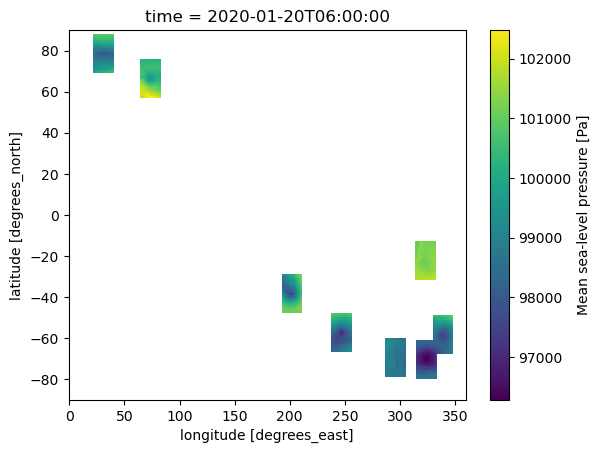

In [1]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob

from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid'
tmpdir='/home/b/b382216/scratch/tmpdir'
fulldir='/home/b/b382216/scratch/fullres'

time = '000120'
infile = os.path.join(indir, f'regrid+{time}_*.nc')
outfile = os.path.join(tmpdir, time + '.nc')
txtfile = os.path.join(tmpdir, 'output_' + time + '.txt')
mslfile=os.path.join(fulldir, f'ICMGGhqys+{time}_msl.nc')
storefile = os.path.join(tmpdir, 'TC_' + time + '.nc')

# read and save the netcdf file to mimic the time lost by the FDB query
tempest_dictionary = readwrite_from_lowres(infile, outfile)
tempest_command = run_detect_nodes(tempest_dictionary, outfile, txtfile)
tempest_nodes = read_lonlat_nodes(txtfile) 

xfield = xr.open_mfdataset(outfile)['MSL']

# set the dimension in degrees of lon/lat of the box around the TCs centre
boxdim=10
gfield = xfield * 0
for k in range(0, len(tempest_nodes['lon'])) :
    box = lonlatbox(tempest_nodes['lon'][k], tempest_nodes['lat'][k], boxdim)
    gfield = gfield + xr.where((xfield.lon > box[0]) & (xfield.lon < box[1]) & (xfield.lat > box[2]) & (xfield.lat < box[3]), True, False)

xfield = xfield.where(gfield>0)

xfield.plot()

In [2]:
# loop on timerecors
for t in range(6000, 6480, 120) : 

    tttt = str(t).zfill(6)
    print(tttt)
    # path definition
    original_file = os.path.join(indir, f'regrid+{tttt}_*.nc')
    netcdf_file = os.path.join(tmpdir, tttt + '.nc')
    txt_file = os.path.join(tmpdir, 'output_' + tttt + '.txt')
    msl_fullres_file=os.path.join(fulldir, f'ICMGGhqys+{tttt}_msl.nc')
   

    # read and save the netcdf file to mimic the time lost by the FDB query
    tempest_dictionary = readwrite_from_lowres(original_file, netcdf_file)

    # run tempest extremes
    tempest_command = run_detect_nodes(tempest_dictionary, netcdf_file, txt_file)
    tempest_nodes = read_lonlat_nodes(txt_file)

    # get the full res field and store the required values around the Nodes
    fullres_field = xr.open_mfdataset(msl_fullres_file)['MSL']
    xfield = store_fullres_field(0, fullres_field, tempest_nodes, boxdim)
    clean_files([netcdf_file])

    # store data every day
    #if (t+120) % (120*4) == 0 : 
        #day = str((t+120) // (120*4)).zfill(3)
    id = tempest_nodes['date']
    print(id)
    print('Storing output')

    # store the file
    store_file = os.path.join(tmpdir, f'TC_MSL_{id}.nc')
    write_fullres_field(xfield, store_file)

    ##reinit xfield
    #xfield = 0


006000
2020020112
Storing output
006120
2020020118
Storing output
006240
2020020200
Storing output
006360
2020020206
Storing output


In [3]:

track_file = os.path.join(tmpdir, 'track.txt')
filenames = glob(os.path.join(tmpdir,'output*.txt'))
stitch_string = run_stitch_nodes(filenames, track_file)


    


Arguments:
  --in <string> ["full_nodes.txt"] 
  --in_list <string> [""] 
  --in_connect <string> [""] 
  --out <string> ["/home/b/b382216/scratch/tmpdir/track.txt"] 
  --in_fmt <string> ["lon,lat,slp,wind"] 
  --range <double> [8.000000] (degrees)
  --mintime <string> ["54h"] 
  --time_begin <string> [""] 
  --time_end <string> [""] 
  --min_endpoint_dist <double> [0.000000] (degrees)
  --min_path_dist <double> [0.000000] (degrees)
  --maxgap <string> ["24h"] 
  --threshold <string> ["wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10"] [col,op,value,count;...]
  --caltype <string> ["standard"] (none|standard|noleap|360_day)
  --allow_repeated_times <bool> [false] 
  --out_file_format <string> ["gfdl"] (gfdl|csv|csvnohead)
------------------------------------------------------------
Parsing thresholds
..wind greater than or equal to 10.000000 at least 10 time(s)
..lat less than or equal to 50.000000 at least 10 time(s)
..lat greater than or equal to -50.000000 at least 10 time(s)
..Done
L

Get the lon/lat from the Stitch Nodes output .txt file

In [5]:
 # open the output file and extract the required lon/lat
track_file = os.path.join(tmpdir, 'track.txt')
reordered_tracks = reorder_tracks(track_file)

xfield = 0
for id in reordered_tracks.keys():

    print(id)
    fullres_file = os.path.join(tmpdir, f'TC_MSL_{id}.nc')
    fullres_field = xr.open_mfdataset(fullres_file)['MSL']

    # get the full res field and store the required values around the Nodes
    #fullres_field = xr.open_mfdataset(msl_fullres_file)['MSL']
    xfield = store_fullres_field(xfield, fullres_field, tempest_nodes, boxdim)

print('Storing output')

# store the file
store_file = os.path.join(tmpdir, 'tempest_tracks.nc')
write_fullres_field(xfield, store_file)

2020020312
2020020318
2020020400
2020020406
2020020412
2020020418
2020020500
2020020506
2020020512
2020020518
2020020600
2020020606
2020020612
2020020618
2020020700
2020020706
2020020712
2020020718
2020020800
2020020806
2020020812
2020020818
2020020900
2020020906
2020020912
2020020918
2020021000
2020021006
2020021012
2020021018
2020021100
2020021106
2020021112
2020021118
2020021200
2020021206
2020021212
2020021218
2020021300
2020021306
2020021312
2020021318
Storing output
